In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)


import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (15, 20)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM

import math
import scipy.stats as ss

In [2]:
#Reading Files
path = "/Users/larst/OneDrive/Documents/GitHub/KaggleS3E21/data/"
data = pd.read_csv(path+"sample_submission.csv")
outliers = pd.read_csv(path+"outliers.csv")
newdata1 = pd.read_csv(path+"train.csv")
newdata2 = pd.read_csv(path+"test.csv")
df = pd.concat([newdata1,newdata2])

In [3]:
newdata1.dropna(inplace=True)
newdata1.rename(columns={"Id": "id"},inplace=True)

In [4]:
for i in range(len(newdata1)):
    newdata1["id"].iloc[i]=10000+i

C:\Users\larst\AppData\Local\Temp\ipykernel_39184\2853504122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata1["id"].iloc[i]=10000+i
C:\Users\larst\AppData\Local\Temp\ipykernel_39184\2853504122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata1["id"].iloc[i]=10000+i
C:\Users\larst\AppData\Local\Temp\ipykernel_39184\2853504122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata1["id"].iloc[i]=10000+i
C:\User

In [5]:
data

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.000,9.545,9.265,8.110,8.430,7.150,0.180,0.200,0.650,14.515,5.845,1.285,0.429,0.030,0.050,0.064,0.730,1.075,0.056,0.567,0.400,1.500,1.560,19.355,4.950,1.730,1.800,4.800,3.150,10.665,10.465,16.645,5.750,10.37
1,1,9.10,13.533,40.900,8.770,9.265,6.015,10.070,7.150,1.107,1.027,1.848,8.625,12.175,0.280,0.440,0.089,1.360,0.064,0.902,1.454,0.056,0.190,2.347,5.105,2.095,19.355,20.050,9.530,7.695,4.550,6.950,2.040,5.200,5.725,2.950,2.23
2,2,8.21,3.710,5.420,8.770,9.265,4.550,10.070,7.150,0.020,0.020,0.650,17.144,24.645,0.380,0.440,0.060,0.050,0.082,0.902,2.025,0.056,0.567,1.700,1.700,3.960,4.900,4.580,3.025,3.960,4.935,4.950,4.725,6.075,6.750,3.500,3.17
3,3,8.39,8.700,8.100,9.500,9.200,5.200,8.670,6.670,0.280,0.270,1.730,3.870,8.410,1.480,1.380,0.050,0.050,0.070,0.530,1.740,0.050,0.064,1.500,1.500,2.020,3.960,8.450,2.070,1.730,6.300,4.700,3.500,6.200,8.670,2.900,7.37
4,4,8.07,8.050,8.650,7.960,9.265,3.290,10.070,7.150,0.360,0.435,0.650,3.850,5.845,0.280,0.440,0.105,0.115,0.074,1.252,1.075,0.071,0.190,1.050,1.150,2.095,3.902,2.020,1.730,0.760,4.800,4.970,3.950,2.800,8.400,3.500,3.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,8.08,6.250,8.300,7.795,9.265,5.690,8.555,6.335,0.565,0.565,3.960,2.400,5.550,0.429,0.440,0.059,0.052,0.120,0.950,0.744,0.067,0.037,1.235,0.210,2.025,7.650,14.575,0.636,1.640,4.235,4.100,2.800,3.950,7.695,3.540,2.50
3496,3496,8.09,6.630,6.630,8.370,7.600,0.636,8.430,7.150,1.300,2.200,1.640,4.140,12.175,1.285,1.570,0.020,0.020,0.026,0.660,0.746,0.037,0.090,1.700,1.620,2.020,4.900,4.580,1.730,1.800,4.900,3.150,2.040,6.075,8.415,2.155,2.90
3497,3497,9.95,8.367,8.433,8.770,6.170,5.800,10.400,7.200,0.430,0.400,1.848,1.800,7.625,0.310,0.844,0.037,0.033,0.026,0.805,1.230,0.056,0.056,2.103,1.620,2.020,19.355,20.050,1.440,1.800,4.867,4.833,4.725,4.950,8.400,6.625,4.20
3498,3498,9.52,10.000,6.630,9.545,9.265,3.290,8.980,2.310,0.300,0.200,1.160,8.625,12.175,1.285,0.429,0.560,0.470,0.208,0.660,1.180,0.140,0.190,1.040,0.550,14.670,19.355,20.050,9.530,7.695,10.700,5.400,4.725,3.300,6.750,6.625,5.00


In [6]:
data = pd.concat([data,newdata1],ignore_index=False)

In [7]:
outliers

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.000,0,9.265,0,0,0,0.180,0,0,0,0,1.285,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.645,0,0
1,0,8.21,3.710,5.420,0,9.265,0,0,0,0.020,0,0,0,0,0.380,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.750,0,0
2,0,8.39,8.700,8.100,0,9.200,0,0,0,0.280,0,0,0,0,1.480,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.670,0,0
3,0,8.07,8.050,8.650,0,9.265,0,0,0,0.360,0,0,0,0,0.280,0,0,0.115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0
4,0,8.12,9.000,9.000,0,9.115,0,0,0,0.240,0,0,0,0,0.280,0,0,0.060,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,0,8.65,8.367,8.760,0,9.265,0,0,0,0.720,0,0,0,0,0.280,0,0,0.040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.415,0,0
2973,0,8.08,6.250,8.300,0,9.265,0,0,0,0.565,0,0,0,0,0.429,0,0,0.052,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.695,0,0
2974,0,8.09,6.630,6.630,0,7.600,0,0,0,1.300,0,0,0,0,1.285,0,0,0.020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.415,0,0
2975,0,9.95,8.367,8.433,0,6.170,0,0,0,0.430,0,0,0,0,0.310,0,0,0.033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0


In [8]:
rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

In [9]:
X, y = data.drop('target', axis = 1), data.target

scores = cross_val_score(rf, 
                         X, 
                         y,
                         cv = 10, 
                         scoring = 'neg_root_mean_squared_error',
                         n_jobs = -1)

print(f'RMSE Mean (BASELINE): {scores.mean()}, Standard Deviation: {scores.std()}')


RMSE Mean (BASELINE): -1.3827451182321144, Standard Deviation: 0.6361490846281539


In [10]:
#clipping
data.target = data.target.clip(lower = 7, upper = 20)
data_added = data.copy()

In [16]:
def preprocess_outliers(data,nu,lofC):
    svm = SGDOneClassSVM(nu=nu)
    yhat = svm.fit_predict(data.drop('id', axis=1))
    mask = yhat != -1
    data_SVM = data.loc[mask, :].reset_index(drop=True)
   

    iso = IsolationForest(random_state=0)
    yhat = iso.fit_predict(data_SVM.drop('id', axis=1))
    mask = yhat != -1
    data_ISO = data_SVM.loc[mask, :].reset_index(drop=True)


    lof = LocalOutlierFactor(n_neighbors=3, contamination=lofC)
    yhat = lof.fit_predict(data_ISO.drop(['id', 'target'], axis=1))
    mask = yhat != -1
    data_final = data_ISO.loc[mask, :].reset_index(drop=True)
  

    return data_final

In [12]:
selected_features = [
    'O2_1', 
    'O2_2',
    'BOD5_5'
    ,'NO2_2'
    ,'O2_4'
    ,'NH4_6'
    ,'NH4_1'
    #,'NH4_5'
    #,'O2_7'
    #,'O2_6'
]

In [13]:
scores = np.array(-1)

In [17]:
import random

In [22]:
while (scores.mean()<-0.87):
    lofC = random.uniform(0.05,0.2)
    nu = random.uniform(0.4,0.7)
    data = data_added.copy()
    data_final = preprocess_outliers(data,nu,lofC)
    X_final, y_final = data_final.drop('target', axis = 1), data_final.target

    # kf = RepeatedKFold(n_splits = 10, n_repeats = 5, random_state = 0)
    scores = cross_val_score(rf, 
                             X_final[selected_features],
                             y_final,
                             cv = 10, 
                             scoring = 'neg_root_mean_squared_error',
                             n_jobs = -1)

    print(f'[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: {scores.mean()}, Standard Deviation: {scores.std()}, {lofC}, {nu}')

[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9479697648346738, Standard Deviation: 0.0812962639817017, 0.08723882804977412, 0.6498567585340762
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9311780617641878, Standard Deviation: 0.09647554126831122, 0.15773183399384727, 0.4761440141725278
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9489692335025955, Standard Deviation: 0.0913039516485817, 0.08260415630536783, 0.4277488770489107
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9072847279501645, Standard Deviation: 0.08577579125383103, 0.18034790076727686, 0.6194938544477602
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9084348821959451, Standard Deviation: 0.08886996943311821, 0.19303818551185964, 0.6152855149814325
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9183560833665227, Standard Deviation: 0.07760447374042956, 0.10967673607570616, 0.5987986538168408
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9053501898641034, Standard Deviation: 0.07976616583879356,

[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9477928147897045, Standard Deviation: 0.0801883984842094, 0.08957903294836814, 0.6559814958122314
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.8960811191081097, Standard Deviation: 0.07549490481897825, 0.13425783116934822, 0.4618568748145057
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9201044729830556, Standard Deviation: 0.07568801496897347, 0.10046953764023549, 0.5660005121935626
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9249987030536918, Standard Deviation: 0.07404665703377797, 0.057443122448541245, 0.6875894616975892
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.8908491512043188, Standard Deviation: 0.07237621984377991, 0.05770482848726309, 0.41423364886234565
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.905735011746998, Standard Deviation: 0.08120168062662461, 0.13060662467605894, 0.623668268186079
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9259712385428036, Standard Deviation: 0.07648915681416416

[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.897397624205794, Standard Deviation: 0.07744579514811661, 0.13467596280915417, 0.5382144363759676
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9296220155873609, Standard Deviation: 0.07566933122855886, 0.06415157506243059, 0.6291300418457783
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9248790332251776, Standard Deviation: 0.07587083475096472, 0.09647306140190572, 0.4192916544923454
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.914287533477473, Standard Deviation: 0.07783626691141822, 0.10681022302141362, 0.42656488046344343
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9021723670116044, Standard Deviation: 0.08505787855801887, 0.12433573008810452, 0.4109911338217323
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.8973034184385723, Standard Deviation: 0.09535097893463826, 0.18793155386119798, 0.41364006791535085
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9125731192563669, Standard Deviation: 0.0908601730729431

[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9078262607984631, Standard Deviation: 0.09105419829697921, 0.19584487751646168, 0.41838863416492206
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9050391788230956, Standard Deviation: 0.08129248988897157, 0.13444340975223062, 0.4198914530278725
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9241659347340677, Standard Deviation: 0.07341711554914031, 0.062431125829979145, 0.4971459286808406
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9282908241521659, Standard Deviation: 0.0836379686041326, 0.05101031245458726, 0.48989106639881325
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.8886687228986107, Standard Deviation: 0.07463756292464166, 0.12367571939521907, 0.6444769492077134
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9074965378555593, Standard Deviation: 0.08225957519794558, 0.14558014825838517, 0.5295212489978276
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.8991441673690733, Standard Deviation: 0.07695402296331

[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.8827583673563175, Standard Deviation: 0.06995203221748143, 0.07669001482460266, 0.430141928999876
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9098257483352177, Standard Deviation: 0.07821009655200749, 0.13867292076830318, 0.47123010144990285
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.8773667834987835, Standard Deviation: 0.08296602908638263, 0.17202569380357158, 0.4954319206566208
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9101729603752006, Standard Deviation: 0.10836692506034401, 0.06489412962549716, 0.5312617847714405
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9328204778817065, Standard Deviation: 0.08359699299185377, 0.05960539985929629, 0.6711263027281837
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.8846805368118572, Standard Deviation: 0.08212867493893994, 0.1892796114449925, 0.598919417845676
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.884942551682905, Standard Deviation: 0.07845220882900703, 

[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9096070462219593, Standard Deviation: 0.08215208540551207, 0.11961730872936788, 0.5517175500797682
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.911164008185124, Standard Deviation: 0.07281973818128444, 0.11225499424359385, 0.6850115246479098
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9089476512238507, Standard Deviation: 0.0813354261173848, 0.1439373995985893, 0.669195104195595
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9196947253643011, Standard Deviation: 0.07292222477452488, 0.07202107648404679, 0.4869116596698883
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.909861740380219, Standard Deviation: 0.07978064849302437, 0.11193038366183064, 0.6123667218483405
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9134543813637, Standard Deviation: 0.07881059605403108, 0.1033969037492655, 0.6265325431832162
[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9094375725047398, Standard Deviation: 0.08356196672282114, 0.1796

In [23]:
def set_unused_features_to_zero(data, selected_features,X):
    for column in X.columns:
        if column not in selected_features:
            data[column] = 0
    return data

In [24]:
data_without_outliers = data_final.copy()
data_without_outliers.to_csv('data_without_outliers2.csv', index = False)

In [25]:
def remove_bad_labels(data, bad_labels):
    data_final = data[~data['id'].isin(bad_labels)]
    return data_final

In [26]:
bad_labels = [2365, 1089, 1936, 1680, 211,2294,448, 437,309,1684]

In [27]:
data_final_no_bad_labels = remove_bad_labels(data_final,bad_labels)

In [28]:
data_final_processed = set_unused_features_to_zero(data_final_no_bad_labels, selected_features,X)

C:\Users\larst\AppData\Local\Temp\ipykernel_39184\1379245579.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = 0


In [29]:
data_final_processed

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,0,9.265,0,0,0,0.180,0,0,0,0,1.2850,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.645,0,0
1,0,9.10,13.533,40.90,0,9.265,0,0,0,1.107,0,0,0,0,0.2800,0,0,1.360,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.725,0,0
2,0,8.21,3.710,5.42,0,9.265,0,0,0,0.020,0,0,0,0,0.3800,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.750,0,0
3,0,8.39,8.700,8.10,0,9.200,0,0,0,0.280,0,0,0,0,1.4800,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.670,0,0
4,0,8.07,8.050,8.65,0,9.265,0,0,0,0.360,0,0,0,0,0.2800,0,0,0.115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940,0,8.30,9.100,8.20,0,10.120,0,0,0,0.140,0,0,0,0,0.3700,0,0,0.020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26.500,0,0
2941,0,8.72,8.100,8.30,0,7.700,0,0,0,0.215,0,0,0,0,0.3600,0,0,0.105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27.120,0,0
2942,0,14.10,11.000,8.60,0,7.260,0,0,0,0.180,0,0,0,0,0.3500,0,0,0.040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.250,0,0
2943,0,8.10,7.500,8.50,0,7.600,0,0,0,0.300,0,0,0,0,1.2850,0,0,0.080,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.415,0,0


In [30]:
submission = data_final_processed.reset_index(drop = True).copy()

submission.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,0,9.265,0,0,0,0.180,0,0,0,0,1.285,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.645,0,0
1,0,9.10,13.533,40.90,0,9.265,0,0,0,1.107,0,0,0,0,0.280,0,0,1.360,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.725,0,0
2,0,8.21,3.710,5.42,0,9.265,0,0,0,0.020,0,0,0,0,0.380,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.750,0,0
3,0,8.39,8.700,8.10,0,9.200,0,0,0,0.280,0,0,0,0,1.480,0,0,0.050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.670,0,0
4,0,8.07,8.050,8.65,0,9.265,0,0,0,0.360,0,0,0,0,0.280,0,0,0.115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.400,0,0


In [31]:
submission.to_csv('submission.csv', index = False)

Text(0.5, 1.0, 'target distribution')

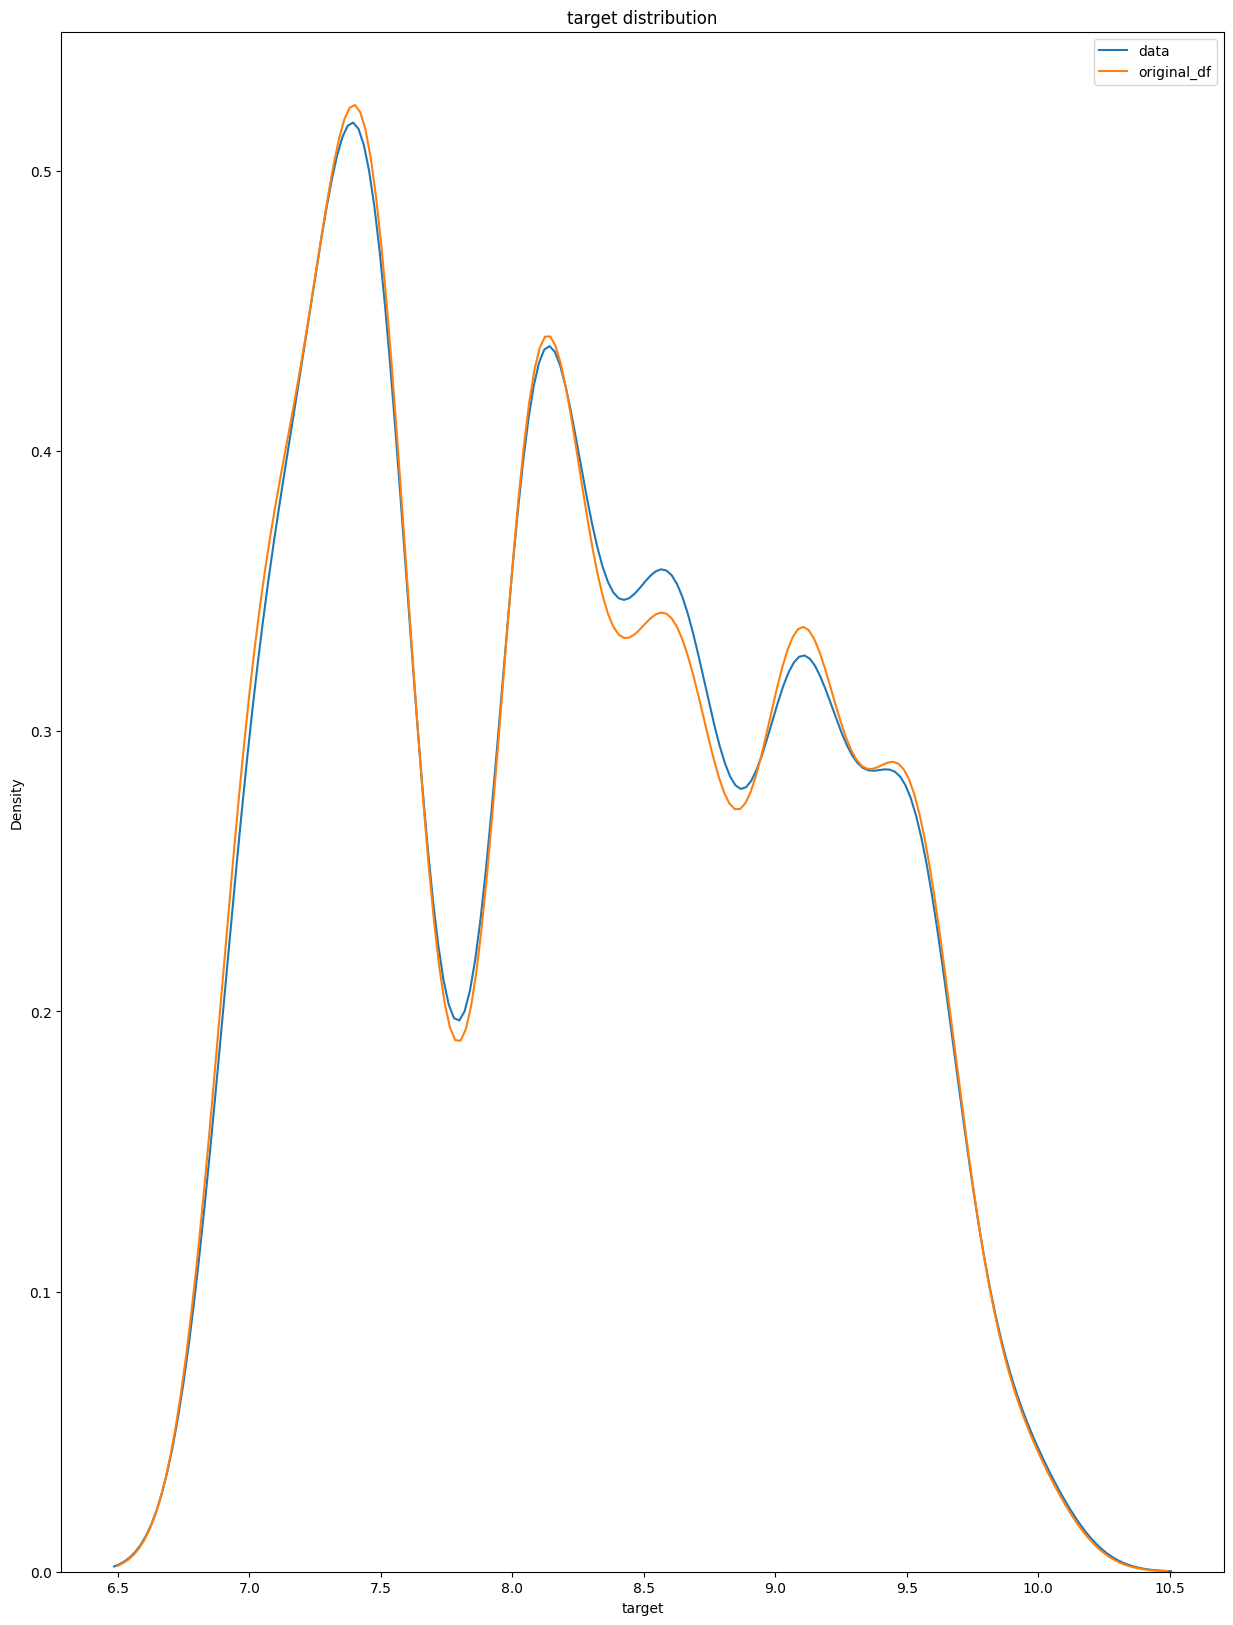

In [32]:
sns.kdeplot(data=submission[submission['target']<10], x="target")
sns.kdeplot(data=data[data['target']<10], x="target")
plt.legend(['data','original_df'])
plt.title('target distribution')

In [ ]:
sns.kdeplot(data=submission[submission['target']<10], x="target")
sns.kdeplot(data=data[data['target']<10], x="target")
plt.legend(['data','original_df'])
plt.title('target distribution')

In [ ]:
submission

In [ ]:
test = submission[submission['target']>7.7]
test = test[test['target']<7.9]

In [ ]:
test

In [ ]:
list_id_delete = test.index.to_numpy()

In [ ]:
drop_index = np.random.choice(list_id_delete,2,replace=False)

In [ ]:
submission = submission.drop(drop_index)

In [ ]:
submission

In [ ]:
submission.to_csv('submission.csv', index = False)